# Yelp Analysis of Hotel Businesses

#### Module 2 – Thursday Group 4

#### Sam W., Hongqian X., Ke T.

In [1]:
%matplotlib inline
%run -i code/plots.py
import matplotlib; matplotlib.rcParams['figure.dpi'] = 300

## Introduction

Yelp is a local-search service powered by a crowd-sourced review forum. It develops, hosts, and markets Yelp.com and the Yelp mobile app, and it publishes the crowd-sourced reviews about local businesses as well as the online reservation service Yelp Reservations. The main goal of this project is to provide useful, analytical insights to hotel and motel business owners and, based on these insights, propose data-driven, actionable decisions to said owners in order to improve their ratings in Yelp. Additionally, we extended our model to make predictions for the ratings associated with every review in the dataset.

The training dataset contains more than 5 million reviews for over 160 thousand businesses across over a thousand categories. Among the top 25 most frequent categories, we found that reviews in the Hotels & Travel category have the lowest average score by a considerable margin. This is understandable, since people spend much more time and money at hotels and thus are likely to be more critical of their experience there. This finding motivated us to explore the Hotels & Travel category. There are 278,733 reviews for 4,833 businesses in Hotels & Travel in the training dataset.

In this report, we use natural language processing methods and a random forest learning model to identify important topics in the reviews. We then analyze those topics to develop business recommendations for hotels.

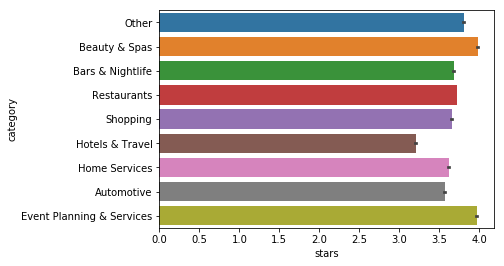

In [2]:
plot_mean_stars_by_category()

## Data Cleaning

*See* `data/functions.py` *for the full data preprocessing code.*

We began by merging the review and business data into a single dataset. There are no missing reviews in the training dataset, but there are quite a few missing business attributes. Since all of these attributes are categorical variables, we chose to add a level representing missing values to each attribute. This way, the model is free to learn the best way to treat missing values. All attributes were then one-hot encoded as a sparse matrix of indicator variables.

We also dropped a number of difficult-to-use features entirely: `city`, `hours`, `name`, `postal_code`, `date`, and several miscellaneous business attributes. We did not believe that any of these dropped features were particularly important for our task.

## Natural Language Processing

*See the* `perform_nlp()` *function in* `data/functions.py` *for the full NLP code.*

The purpose of natural language processing is to convert messy text to a numerical vector representation. We took a bag-of-words approach in order to achieve this goal. Our NLP consisted of the following steps:

1. Split the text into a list of lowercase words; keep only letters and apostrophes.
2. Identify the part of speech (noun, verb, adjective, etc.) associated with each word.
3. Use the part of speech information to convert each word to its root form using the Wordnet database.
4. Identify noun phrases in the text using the part of speech information.
5. Calculate the Tf-Idf value for each word and noun phrase.

The third step is called "lemmatization". For example, the verbs "cooks", "cooked", and "cooking" would all be mapped to the word "cook". This is helpful because it allows us to represent several different forms of the same word with a single feature identifier. Using the part of speech information makes the process much more accurate than other algorithmic methods such as stemming.

The Tf-Idf value for a word (or a phrase) in a text is defined as:

$\text{Tf-Idf}(\text{term, text}) = \frac{\text{Number of occurrences in text}}{\text{Number of terms in text}} \cdot \text{ln}\Big(\frac{\text{Number of texts}}{\text{1 + Number of texts containing term}}\Big)$

The first term (the "Term frequency") captures the frequency of a word or phrase in the review. The second term (the "Inverse document frequency") penalizes words if they occur in many of the reviews. The hope is that this value will strike a balance between the the frequencies and importances of words that appear in the reviews. Additionally, we applied an L2 norm to the output rows, which tends to improve the performance of most models.

Our final feature set consisted of the 20,000 most frequent words and phrases (in addition to the business attributes). Additionally, we chose not to remove stop words from our our dataset. Most of the most popular stop word lists contained words which we were hesitant to remove since they might be useful for our prediction model. We decided instead to take a hands-off approach and let the model decide whether or not each word is useful for making predictions.

## Obtaining Feature Importances

*See* `data/hotel_model.py` *for the full code associated with this model.*

In order to develop recommendations for hotel businesses, we needed to determine the relative importance of the features in our dataset. Since our feature space is extremely high dimensional, and because variable interactions are more important for bag-of-words data, a linear model is not effective at addressing the problem. Instead, we opted for a random forest of regression trees. The random forest model provides several benefits:

* It is known to perform well on high dimensional data.
* It is nonparametric, which is useful because it would be burdensome to verify the distributional shape and properties of such a sparse, high-dimension dataset.
* It allows us to calculate the relative importance of each feature. The structure of a random forest is more intuitive than other tree-based methods (e.g., gradient boosting).
* Cross-validation is not required because we can directly estimate the accuracy using out-of-bag samples (gradient boosting does not have this characteristic).

The splits in our forest's decision trees are made based on the Gini impurity measurement. The importance of feature $X$ is calculated as follows:

1. For each $X$ node in a tree, measure the total decrease in the Gini impurity at the node.
2. Calculate the sum of these decreases in the tree, weighted by the proportion of samples that reach each node.
3. Average these sums across all trees.

## Predictive Model

*See* `data/prediction_model.py` *and* `data/random_search.py` *for the full code associated with this model.*

In order to generate predictions for the full test set of reviews, we swapped the random forest model for gradient-boosted trees. The accuracy of gradient boosting is known to be competitive with neural networks while still maintaining interpretability. The implementation we used was XGBoost, which trains quickly by utilizing a GPU and approximation methods.

We tuned 7 hyperparameters in total for the model. Since this is quite a few parameters, we decided against a grid search in favor of a randomized search. We randomly sampled sets of parameters in the parameter space from reasonable distributions and evaluated the model accuracy for each set. We chose the set which performed the best and trained the final model on all of the training data using those parameters.

This model attained a root mean-squared error of **0.75853** on the test set.

## Recommendations

We used the feature importances to rank the most frequent words and phrases by importance. We also analyzed a larger set of noun phrases separately using the spearman correlation coefficient (a nonparameter method appropriate for both continuous and discrete variables) to find important phrases. From there, we manually grouped the phrases around specific topics by pulling example reviews containing those features.

Using this analysis, we can now present our business recommendations to hotel owners as well as statistical evidence to support those suggestions. We tried to focus on providing insights that are feasible for business owners. For example, it is not realistic to suggest that a hotel owner rebuild their hotel to enlarge the rooms (a common complaint in the reviews is that the rooms are small), but it is realistic to suggest that they clean the rooms better.

### 1. Train Staff Better

The most frequent and prominent topic in Yelp reviews for hotels is the behavior of the staff, employees, and customer service. Shown below are a number of words and phrases related to staff behavior that were among the most important in the random forest model:

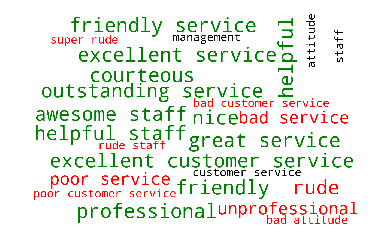

In [3]:
plot_staff_training_cloud()

We formed two groups of reviews: the "positive" group containing reviews where any of the positive (green) terms appear and the "negative" group containing reviews where any of the negative (red) terms appear. The mean review scores for these two groups was **3.67** and **1.54**, respectively, which is a very large difference. A $t$-test of this difference was significant at a level of $\alpha=0.05$.

Because of this, we strongly recommend that hotel owners incorporate training procedures for their staff which emphasizes friendliness, helpfulness, and professionalism.

### 2. Improve Cleanliness

The next most frequent topic was the cleanliness of the businesses. The phrases and words related to this were very important for the model:

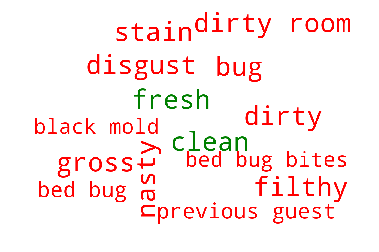

In [4]:
plot_cleanliness_cloud()

Again, we formed a "positive" and a "negative" group of reviews containing the positive and negative terms from above, respectively. The average review scores in these two groups was **3.55** and **1.89**, which is another large difference. A $t$-test of this difference was significant at a level of $\alpha=0.05$.

Improving cleanliness does not require large investments of time or money. Hotels already have staff to clean and maintain rooms and facilities. We strongly recommend that they hire more cleaning staff or retrain staff to do a better job of cleaning, since it is a major concern for so many guests.

### 3. Ensure High-Quality Restaurants

The last major topic of importance in the review set was the restaurants and food options at the hotel:

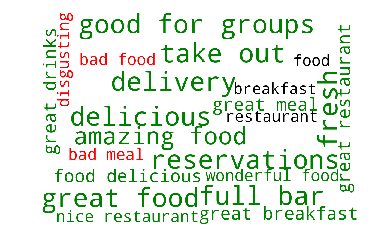

In [5]:
plot_food_cloud()

Reviewers had a range of complaints about the food options at hotels. The most common complaints are that the food did not taste good, the restaurant did not offer take-out or delivery, or the atmosphere of the restaurant was bad.

The average review scores for reviews containing the positive and negative terms, respectively, were **3.31** and **3.24**. While this difference is not as large as the previous topics, a $t$-test of this difference was still significant at a level of $\alpha=0.05$. More importantly, food options is still one of the most frequent topics in the reviews and words relating to this topic are very important for the model. For this reason, we suggest that hotels hold their restaurants to high standards. In addition, these restaurants should offer take-out and delivery options for guests, since this is a common complaint.

### Miscellaneous Recommendations

Lastly, there were a few topics that came up frequently throughout the reviews and which are simple considerations for most business owners.

#### People Love Coffee

"Coffee" is an extremely frequent word in the reviews. When we looked at the most frequent phrases in reviews that contained the word "coffee", we found that "coffee maker", "coffee pot", "coffee shop", and "free coffee" are mentioned often. Many example reviews we looked at contained complaints or praises about coffee shops in the hotel or the availability of free coffee.

It's a good idea to make sure your hotel has a decent coffee shop in it for guests to visit. In addition, we highly recommend putting coffee machines and free coffee in hotel rooms for the guests. This is a simple and inexpensive thing to do, but it is very important to people.

#### People Love Pools and Hot Tubs

Lots of reviewers had good things to say about the pool and hot tub(s) in their hotel. In fact, for reviews where people mention a pool or hot tub, the average score is **3.55**. In comparison, the average score for the other reviews is **3.21**. A $t$-test of this difference was significant at a level of $\alpha=0.05$. This difference is quite large for a single hotel characteristic. We recommend that hotel owners who are renovating or constructing hotels spend some money on a good pool and a few hot tubs for the guests.

#### Free WiFi

The words "WiFi" and "internet" appear with some frequency in the dataset. Upn investigation, hotels marked as having free WiFi had an average review score of **3.29** versus **3.17** for those with paid WiFi. A $t$-test of this difference was significant at a level of $\alpha=0.05$. From a hotel's point of view, making WiFi freely accessible for guests is an incredibly easy and inexpensive thing to do, so we definitely recommend doing so.

#### Extra Fees

Another common occurrence in the reviews is phrases like "extra fees", "additional charges", "fine print", etc. These tend to be negatively correlated with review ratings since customers don't like being charged for every little thing they do. Since these fees are often small, miscellaneous charges, hotels might consider reducing the number of extra fees they charge. It is likely that it wouldn't be a large financial burden for the hotels, yet it would help to improve the experience of its guests.

#### Security

A number of reviews complement or complain about the security at the hotel. Hotels may want to consider adding a few security guards to their hotels (or making the existing security guards more visible to guests).

#### Noise Levels

Another frequent topic among reviewers is the noise levels around their hotel rooms. Soundproofing hotel rooms or responding more consistently to noise complaints may be a good way to alleviate these problems.

### Conclusion

In summary, there are a number of ways that hotel owners could significantly improve the experiences of their guests. Some of the suggestions we've made -- such as improving staff training, better restaurants, or having pools and hot tubs -- require some time and money investment. However, other recommendations -- such as making the WiFi free, putting free coffee in hotel rooms and making sure the hotel rooms are extra clean -- are fairly simple and cheap changes to make. We highly recommend hotels take these suggestions into consideration, since better guest experiences and reviews will result in more new and returning customers.